# Greenland Surface Melt Analysis

In [4]:
# fetching data from API
import requests

# processing and plotting data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# sklearn utils
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# context variables
plt.style.use('bmh')
np.random.seed(42)

## Fetching data from NSIDC API

The NSIDC website <https://nsidc.org/greenland-today/greenland-surface-melt-extent-interactive-chart/> shows the Greenland Ice Melting Interactive Chart. Here, we have pulled out the raw data from their API.

### Acknowledgements
Greenland Ice Sheet Today is produced at the National Snow and Ice Data Center by Ted Scambos, Julienne Stroeve, and Lora Koenig with support from NASA. NSIDC thanks Jason Box, Xavier Fettweis, and Thomas Mote for data and collaboration

In [5]:
data = {}
for i in range(1979, 2023):
  url = f"https://nsidc.org/api/greenland/melt_area/{i}"
  response = requests.request("GET", url)
  data = data | response.json()

## Data
Making a dataframe, from the data fetched above, with the following columns:
- date: Date on which the information was recorded
- melt_km_2: The amount of ice melted until that date

In [6]:
df = pd.DataFrame.from_dict(data, orient='index').reset_index()
df.columns = ['date', 'melt_km_2']
df.head()

,date,melt_km_2
0,1979-04-02T00:00:00.000Z,0.0
1,1979-04-04T00:00:00.000Z,0.0
2,1979-04-06T00:00:00.000Z,0.0
3,1979-04-08T00:00:00.000Z,6000.0
4,1979-04-10T00:00:00.000Z,0.0


# Feature Engineering

Detecting NAN values(missing values), and dropping them

In [7]:
df.isna().sum()

date           0
melt_km_2    133
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isna().sum()

date         0
melt_km_2    0
dtype: int64

Converting 'date' column, from _str_ to _date_ format, and forming 3 new features from the date- _day_, _month_, and _year_.

Following that, the datafram is sorted.

In [9]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df.sort_values(by=['date'])
df.head()

,date,melt_km_2,day,month,year
0,1979-04-02 00:00:00+00:00,0.0,2,4,1979
1,1979-04-04 00:00:00+00:00,0.0,4,4,1979
2,1979-04-06 00:00:00+00:00,0.0,6,4,1979
3,1979-04-08 00:00:00+00:00,6000.0,8,4,1979
4,1979-04-10 00:00:00+00:00,0.0,10,4,1979


In [10]:
df.describe()

,melt_km_2,day,month,year
count,8.321000e+03,8321.000000,8321.000000,8321.000000
mean,1.001533e+05,15.762288,7.011056,2002.604975
std,1.562355e+05,8.829255,1.999188,11.855665
min,0.000000e+00,1.000000,3.000000,1979.000000
25%,1.000000e+03,8.000000,5.000000,1993.000000
50%,1.800000e+04,16.000000,7.000000,2003.000000
75%,1.510000e+05,23.000000,9.000000,2013.000000
max,1.464000e+06,31.000000,10.000000,2022.000000


## Data Exploration

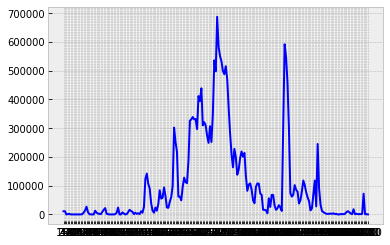

In [11]:
by_year = lambda year: df[df['date'].dt.year == year]
plot_by_year = lambda year, col: plt.plot(
    by_year(year)['day'].astype(str) + '-' + by_year(year)['month'].astype(str), 
    by_year(year)['melt_km_2'], c=col)
plot_by_year(2022, 'blue')

Comparing years - 2020, 2021 and 2022

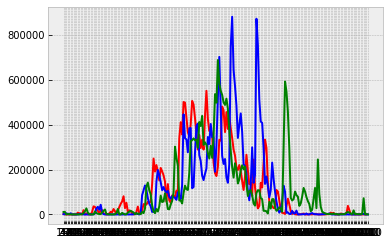

In [12]:
plot_by_year(2020, 'red')
plot_by_year(2021, 'blue')
plot_by_year(2022, 'green')

Maximum Melt (km<sup>2</sup>) per Year


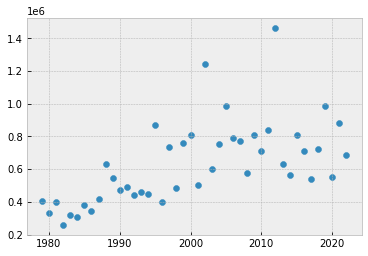

In [13]:
# SELECT max(value) FROM df
# GROUP BY year 

year_max = df.groupby(['year'])['melt_km_2'].max()
plt.scatter(year_max.index, year_max)

Total Melt (km<sup>2</sup>) per Year


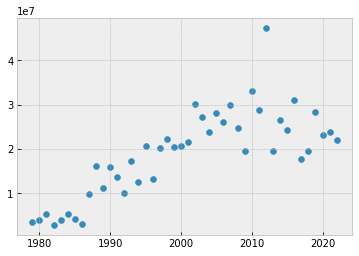

In [14]:
year_sum = df.groupby(['year'])['melt_km_2'].sum()
plt.scatter(year_sum.index, year_sum)

Average Melt (km<sup>2</sup>) per Year

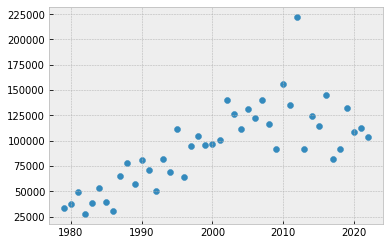

In [15]:
year_avg = df.groupby(['year'])['melt_km_2'].mean()
plt.scatter(year_avg.index, year_avg)

In [16]:
df_year_sum = pd.DataFrame(year_sum).reset_index()
df_year_sum.head()

,year,melt_km_2
0,1979,3531000.0
1,1980,3991000.0
2,1981,5291000.0
3,1982,2742000.0
4,1983,4030000.0


## Forecasting Yearly Total Melt 

In [17]:
X = np.array(df_year_sum['year']).reshape(-1,1)
y = np.array(df_year_sum['melt_km_2'])
X[0:5], y[0:5]

(array([[1979],
        [1980],
        [1981],
        [1982],
        [1983]]), array([3531000., 3991000., 5291000., 2742000., 4030000.]))

Splitting data into training and test sets. 


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42
)

Defining util functions

In [19]:
def train_test(model):
    '''
    function to train a model (e.g.linear regression model) on the training set
    and evaluate on both training and test sets
    '''
    model.fit(X_train, y_train)
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    return model

def plot_results(model):
    '''
    function for plotting the predictions of a  model and compare with
    training and test data
    '''
    fig, ax = plt.subplots(1,2)
    ax[0].scatter(X_train, y_train)
    ax[0].scatter(X_train, model.predict(X_train), c='red')
    ax[0].set_title('Train Data')

    ax[1].scatter(X_test, y_test)
    ax[1].scatter(X_test, model.predict(X_test), c='red')
    ax[1].set_title('Test Data')

    plt.show()

##Linear Regression

A simple linear regression model


In [20]:
l_reg = train_test(LinearRegression())

Train Score: 0.5664001237549569
Test Score: 0.7859603679785122


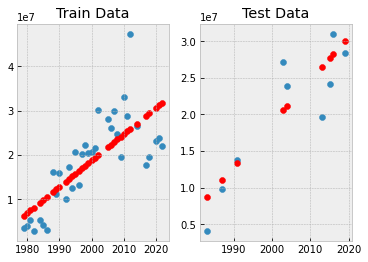

In [21]:
plot_results(l_reg)

We can see that the linear regression model is under-fitted. Even though it somewhat describes the trend, it does not capture the distribution that well.

## Polynomial Regression

Since a linear model was not enough, we can try a polynomial model.

In [53]:
poly_reg = train_test(make_pipeline(PolynomialFeatures(degree=3), LinearRegression()))

Train Score: 0.7683867507290087
Test Score: 0.7866659088901111


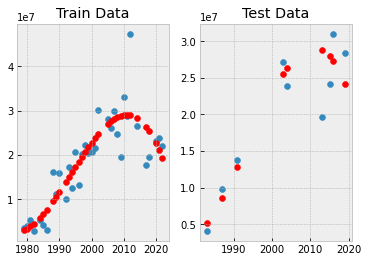

In [27]:
plot_results(poly_reg)

We can see that a polynomial model is much better at capturing the distribution of the data.

## Decision Tree

A decision tree regressor to try and capture the non-linear nature of the data. 

In [22]:
dtree = train_test(DecisionTreeRegressor(max_depth=2, random_state=42))

Train Score: 0.7611158798544709
Test Score: 0.8184010055704072


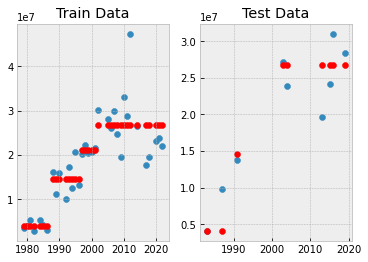

In [23]:
plot_results(dtree)

While the decision tree performs better at capturing the distribution of the data, there is still room for improvement.

## Random Forest

Since a decision tree performed well but was weak, we can try random forest - an ensemble of multiple decision trees.

In [24]:
rf = train_test(RandomForestRegressor(n_estimators=100, max_depth=2, random_state=42))

Train Score: 0.7831141162071042
Test Score: 0.8208394577355081


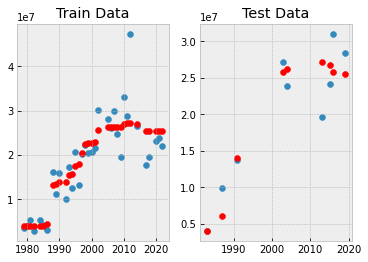

In [25]:
plot_results(rf)

Even though the performance bump is not huge, it captures the distribution of the data quite well.

## Forecasting Daily Melt

In [28]:
df.head()

,date,melt_km_2,day,month,year
0,1979-04-02 00:00:00+00:00,0.0,2,4,1979
1,1979-04-04 00:00:00+00:00,0.0,4,4,1979
2,1979-04-06 00:00:00+00:00,0.0,6,4,1979
3,1979-04-08 00:00:00+00:00,6000.0,8,4,1979
4,1979-04-10 00:00:00+00:00,0.0,10,4,1979


Let's have a look at the overall trend of melt amounts (km<sup>2</sup>)

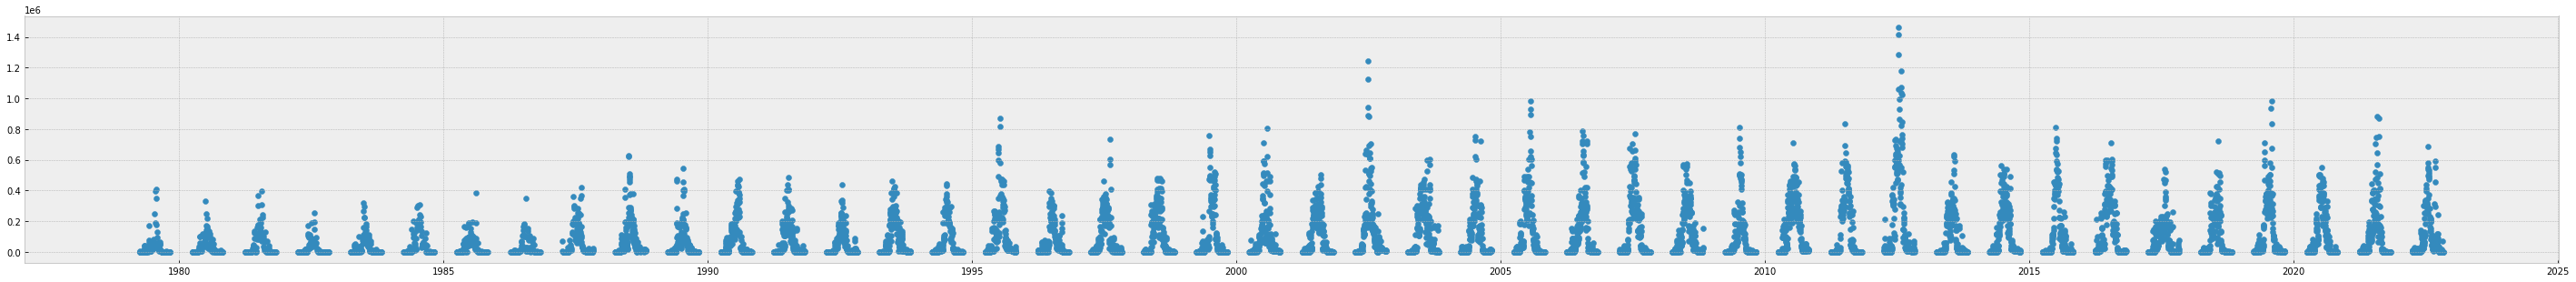

In [29]:
plt.figure(figsize=(50, 5))
plt.scatter(df['date'], df['melt_km_2'])

There seems to be some periodicity to the data which a linear model might not be able to capture.

Splitting data into training and test sets

In [30]:
X_whole, y_whole = df.drop(['date', 'melt_km_2'], axis=1).values, df['melt_km_2'].values
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(X_whole, y_whole, test_size=0.3, random_state=42)

Defining util functions

In [56]:
def train_test_2(model):
    '''
    function for training a model using cross-validation on the training set
    and evaluating using the test data
    '''
    model.fit(X_train_whole, y_train_whole)
    train_score = cross_val_score(model, X_train_whole, y_train_whole, cv=5)
    test_score = model.score(X_test_whole, y_test_whole)
    print(f'Cross-val: mean = {train_score.mean()} | std = {train_score.std()}')
    print(f'Test Score: {test_score}')

    return model


def plot_results_2(model):
    '''
    function for plotting the predictions of a  model and compare with
    training and test data
    '''
    
    df_train_plot = pd.DataFrame(
        X_train_whole, 
        columns=['day', 'month', 'year']
    )
    day = df_train_plot['day'].astype(str)
    month = df_train_plot['month'].astype(str)
    year = df_train_plot['year'].astype(str)
    df_train_plot['date'] = pd.to_datetime(
        f'{day}/{month}/{year}', 
        dayfirst=True
    )
    df_train_plot['y_train'] = y_train_whole
    df_train_plot['y_pred'] = model.predict(X_train_whole)

    df_test_plot = pd.DataFrame(X_test_whole, columns=['day', 'month', 'year'])
    day = df_test_plot['day'].astype(str)
    month = df_test_plot['month'].astype(str)
    year = df_test_plot['year'].astype(str)
    df_test_plot['date'] = pd.to_datetime(
        f'{day}/{month}/{year}', 
        dayfirst=True
    )
    df_test_plot['y_train'] = y_test_whole
    df_test_plot['y_pred'] = model.predict(X_test_whole)

    fig, ax = plt.subplots(2, figsize=(50,5))
    ax[0].scatter(df_train_plot['date'], df_train_plot['y_train'])
    ax[0].scatter(df_train_plot['date'], df_train_plot['y_pred'], c='red')
    ax[0].set_title('Train Data')

    ax[1].scatter(df_test_plot['date'], df_test_plot['y_train'])
    ax[1].scatter(df_test_plot['date'], df_test_plot['y_pred'], c='red')
    ax[1].set_title('Test Data')

    plt.show()

def plot_forecast(model, date_range):
    '''
    function for plotting the forecast data given by a  model in a given date 
    range
    '''

    forecast_24_27 = []
    for each_date in pd.date_range(start=date_range[0], end=date_range[1]):
        forecast_24_27.append([each_date.day, each_date.month, each_date.year])
    
    df_forecast_plot = pd.DataFrame(
        forecast_24_27, 
        columns=['day', 'month', 'year']
    )
    day = df_forecast_plot['day'].astype(str)
    month = df_forecast_plot['month'].astype(str)
    year = df_forecast_plot['year'].astype(str)
    df_forecast_plot['date'] = pd.to_datetime(
        {day}/{month}/{day}, 
        dayfirst=True
    )
    df_forecast_plot['y_forecast'] = model.predict(forecast_24_27)

    plt.figure(figsize=(50, 5))
    plt.scatter(
        df_forecast_plot['date'], 
        df_forecast_plot['y_forecast'], 
        c='red'
    )

    plt.show()


## Random Forest

Since it performed well in modelling the yearly total melt and was able to capture a non-linear relationship, we can try random forest to forecast daily melt. 

In [32]:
rf_whole = train_test_2(RandomForestRegressor(max_depth=20))

Cross-val Train Score: mean = 0.811026560175468 | std = 0.02277645689685194
Test Score: 0.8471884610539401


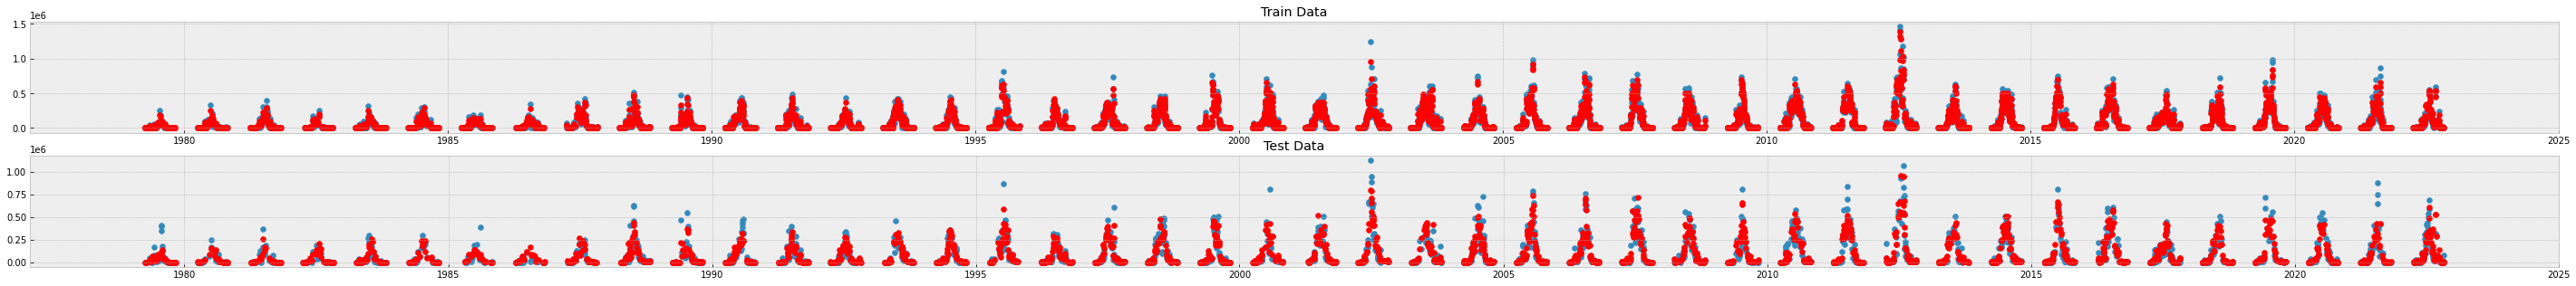

In [33]:
plot_results_2(rf_whole)

The model does well to learn the distribution of data. 

We can also look at the forecast for the next 4 years (2023-2027).

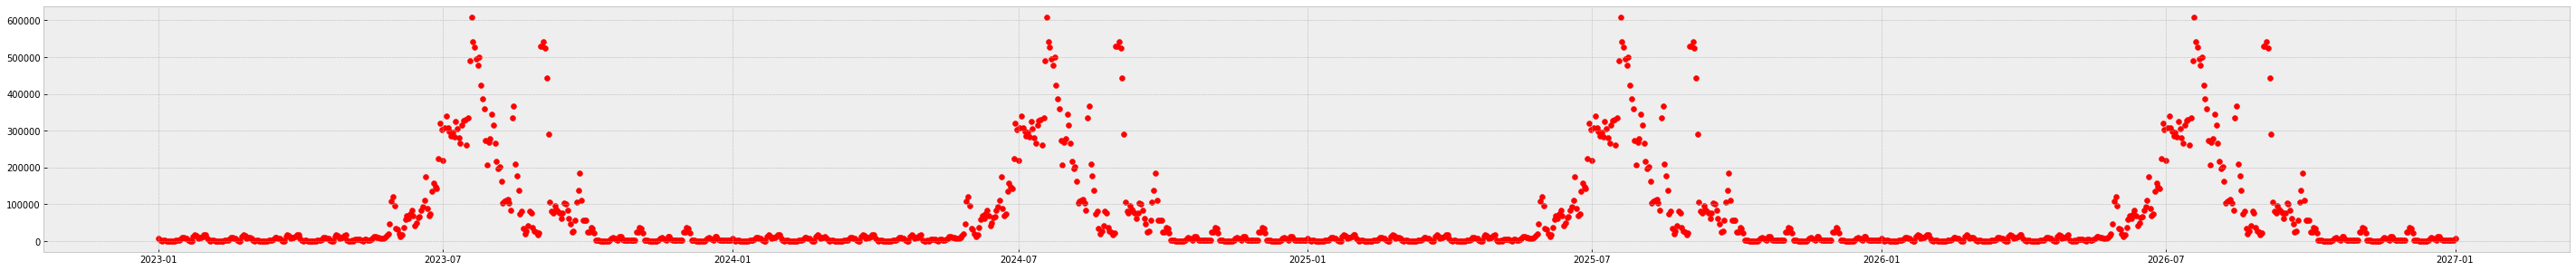

In [34]:
plot_forecast(rf_whole, ['1/1/2023', '1/1/2027'])

## Polynomial Regression

Checking the performance of a polynomial model.

In [35]:
poly_reg_whole = train_test_2(make_pipeline(PolynomialFeatures(degree=5), LinearRegression()))

Cross-val Train Score: mean = 0.5418144121876676 | std = 0.04741998933817843
Test Score: 0.5812696429156354


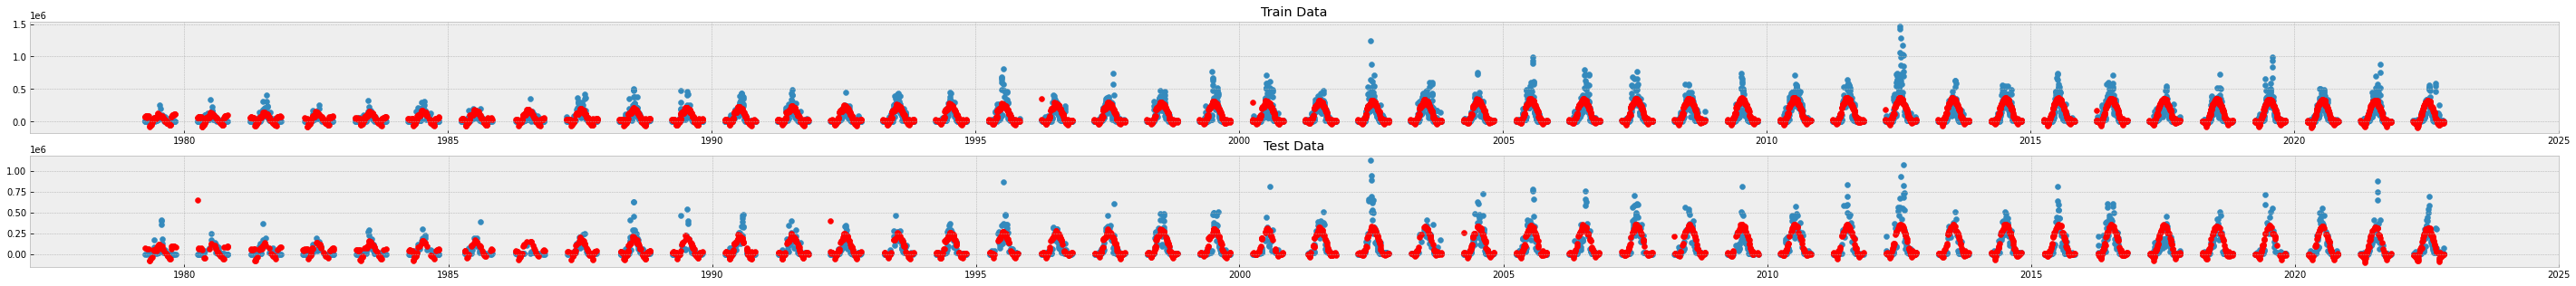

In [36]:
plot_results_2(poly_reg_whole)

It does not perform as well as the random forest model. 

Let us see the forecast.


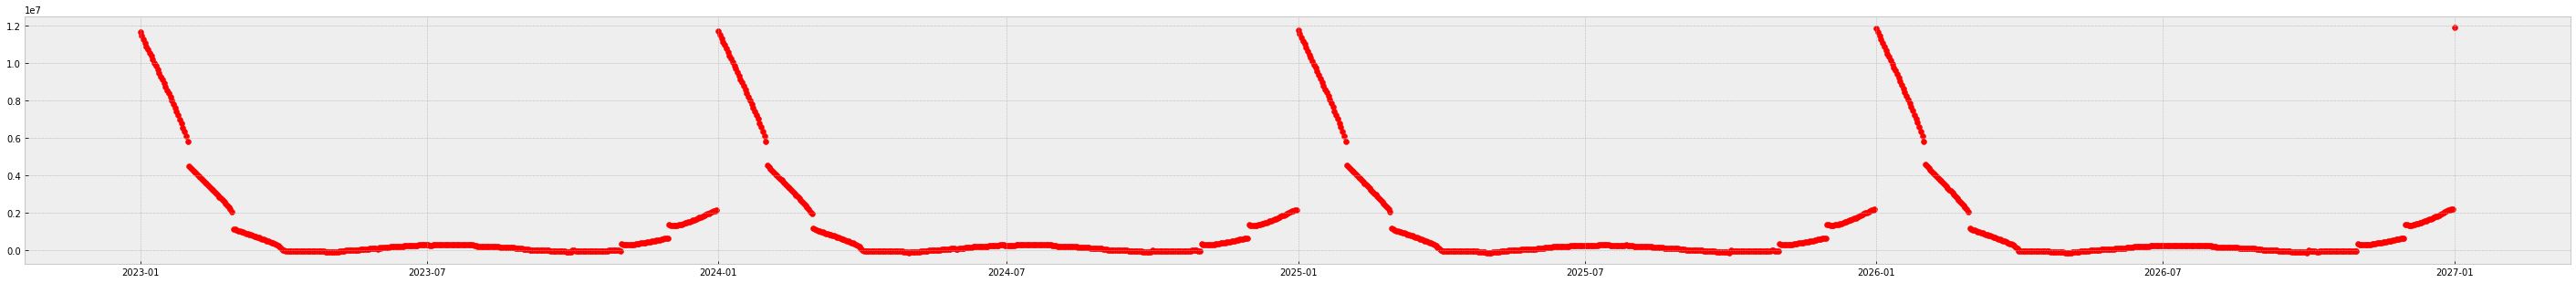

In [37]:
plot_forecast(poly_reg_whole, ['1/1/2023', '1/1/2027'])

## Conclusion

We looked at many models for forecasting the yearly and daily amount of ice melting in Greenland. The best model for forecasting yearly and daily data was the random forest which is ensemble of decision trees, that helps it generalise to a non-linear (and possibly periodic) distribution of data. 